<a href="https://colab.research.google.com/github/u-keigo/RRIproject1/blob/main/SVNS%E5%88%86%E9%A1%9E%E3%83%A2%E3%83%87%E3%83%AB4_1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Basic LSTM for SV/NS of CHF 

大家がkerasでなんとしてもやってくれるらしい

In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
import pickle
import pandas as pd
import numpy as np

select = 7   # SGfilterのスケールを決定する変数 [5, 7, 11, 15, 21, 29, 41, 57, 81, 113, 161, 227, 321]
batch_size = 64   # バッチサイズ
num_epochs = 100  # エポック数
# hidden_size = 216  # 隠れ層の数
unit_size = 64
dropout = 0.25  # LSTMのdropoutの割合(過学習を防ぐ)
# dropout = 0
data_num = 70   # データの長さを1/data_numし、データ数をdata_num倍する

# filename = '/content/drive/MyDrive/SVNS_df70000_DMA0.sav'
filename = '/content/drive/MyDrive/SVNS_df70000_DMA2.sav'
# filename = '/content/drive/MyDrive/SVNS_df70000_DMA4.sav'


with open(filename, 'rb') as web:
  DAT = pickle.load(web)   # 108 * 13 * 70000の形

ii = 0
n = 0
scale = []
while ii <= 300:
  ii = int(5*np.sqrt(2)**n)
  scale.append(int(ii/2)*2 + 1)
  n += 1
print(scale)
print('SG Filter scale : {}'.format(scale[select]))

filename = '/content/drive/MyDrive/SVNS_df_108_70000.sav'

DAT5 = pd.DataFrame(DAT[:,select,:])

with open(filename, 'rb') as web:
  DAT5.index = pickle.load(web).index   # DAT5 = DAT4

DAT5.head()

[5, 7, 11, 15, 21, 29, 41, 57, 81, 113, 161, 227, 321]
SG Filter scale : 57


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,69960,69961,69962,69963,69964,69965,69966,69967,69968,69969,69970,69971,69972,69973,69974,69975,69976,69977,69978,69979,69980,69981,69982,69983,69984,69985,69986,69987,69988,69989,69990,69991,69992,69993,69994,69995,69996,69997,69998,69999
SV_24h,21.205815,18.275321,10.561201,-14.416886,-35.844087,0.854153,5.600602,3.267055,1.032999,-1.101565,-2.934107,1.661956,2.902788,-16.642031,-37.074320,0.780468,13.418291,15.207861,13.968717,12.829064,11.685006,4.146933,0.331395,-0.410293,-1.052490,-1.595196,-2.038411,-7.524991,-8.680616,-6.432232,-15.952951,-18.803920,-19.538879,-19.307996,-19.662886,-19.389407,-12.332620,-8.739482,-7.598301,-5.928333,...,42.333481,60.084678,44.076330,45.206663,54.270612,65.415020,79.093747,89.631575,90.305723,86.339638,87.890710,111.808823,80.392974,14.413539,-23.767801,-61.813973,-96.228438,-113.937056,-119.674714,-125.881476,-158.345775,-176.741527,-175.114843,-157.420270,-141.989579,-134.219833,-125.533712,-97.989469,-40.402639,-33.010406,-45.158787,-40.765795,-24.948774,8.998121,72.707545,99.206253,83.241685,93.966687,139.858824,223.892595
NS_24h,46.630431,86.077317,106.487646,77.730983,44.416024,22.187322,25.477867,24.427240,18.096486,11.511783,-25.708890,-66.066797,-60.760284,-61.623939,-75.180512,-94.310183,-123.542092,-143.313022,-114.368830,-36.709514,51.538722,29.642900,-11.982265,-45.195933,-62.874076,-50.345486,-16.989250,-32.274061,-53.183787,-62.180297,-38.278847,-10.552530,-8.450968,-27.660484,-46.128403,-34.115218,-4.225456,30.846355,23.821110,19.902343,...,0.681471,28.840509,42.903818,27.675881,-0.842137,-10.690402,0.614477,37.374077,72.655482,74.766707,57.411545,28.930439,11.437518,8.462461,11.971081,19.850719,6.995758,-20.700944,-46.810816,-59.333858,-44.846341,-25.813114,-18.236536,-22.376543,-38.322578,-21.591306,28.297810,58.034626,68.333595,62.201376,43.316951,16.845044,-2.049207,-5.963771,1.034936,16.069399,-0.019588,-29.781491,-39.938546,-38.189272
SV_24h,-23.690856,-15.837322,-13.829828,-9.455286,-5.362096,-3.315860,2.863027,2.580956,9.079938,10.331813,9.570982,8.741887,7.844530,6.878909,5.845026,4.742880,10.147814,11.409142,10.102208,8.727010,7.283550,5.771827,4.411019,9.831263,10.114751,3.315892,-2.537145,-1.554336,2.678323,1.983367,1.077047,0.078737,4.379124,6.730652,5.370425,3.656079,1.774524,-0.338583,-2.769635,0.477928,...,24.849492,23.528308,9.331038,2.094527,5.443156,7.209366,6.942928,6.579545,9.148515,14.180098,17.387289,19.265149,3.440646,-20.238544,-47.034918,-68.004879,-94.062085,-121.253049,-145.970179,-164.213474,-176.042496,-187.223180,-201.522178,-203.858513,-205.871613,-209.675881,-207.135464,-198.303794,-183.215258,-161.905508,-144.982604,-121.612562,-81.402909,-24.841548,40.321520,106.211297,182.623699,265.966891,350.036791,443.073399
NS_24h,14.573080,8.990223,7.981001,5.289436,-5.930542,-4.675652,-1.612559,-1.970277,-4.871028,-1.469749,2.110103,-2.990983,-12.452752,-15.547060,-12.339339,-2.894027,2.660963,-2.525744,-13.912375,-12.824137,4.619040,19.773824,4.277446,19.030740,9.873792,-6.258511,-8.611624,-10.835547,-6.806824,7.726443,12.655654,-13.933697,7.442957,7.352030,0.698110,5.859112,5.014245,-1.933059,-6.181333,-4.265945,...,-15.533399,-15.303191,-15.106455,-15.005308,-8.767657,-1.512034,10.224640,9.122380,-6.666740,-0.529494,-1.827314,-3.282021,0.772534,7.179092,7.228944,-0.606069,-1.738097,3.752147,3.020533,0.620188,2.193468,7.524156,11.076525,7.638245,-2.878963,4.313790,7.109046,3.632831,2.616727,6.871545,10.882290,7.909236,-2.128286,-5.005998,-4.930448,-7.158209,-3.844777,-0.665829,-11.176921,-7.786941
NS_24h,-50.622758,-13.703218,23.506082,55.805144,81.251109,88.541813,65.819248,33.944979,27.540327,39.349382,28.891807,-2.610193,-5.453639,20.361471,20.555594,-21.268214,-68.242863,-103.649555,-119.804081,-110.668846,-88.949732,-81.646740,-86.642222,-91.347943,-95.763904,-99.890103,-103.726542,-87.888605,-47.285382,2.852601,45.217286,76.7

In [115]:
# 列数をnum分割するようにデータフレームをreshapeする関数
# shape(108,10000) → shape(540,2000)

import pandas as pd
import numpy as np

def df_reshape(df, num):
  M = df.shape[0]   # 108
  N = df.shape[1]   # 10000
  
  df_new = pd.DataFrame(np.zeros(shape=(int(M*num), int(N/num))))

  count = 0
  for i in range(M):   # range(3) = 0,1,2
    for j in range(num):
      df_new = df_new.rename({count:df.index[i]},axis=0)   # indexの置換
      start = int(N/num)*j
      goal = int(N/num)*(j+1)   # 1:5 = 1,2,3,4
      df_new.iloc[count] = df.iloc[i, start:goal].to_numpy()   # 値だけ抽出するためにnumpy配列に変換
      count += 1
  
  return df_new

# データの長さを1/data_numし、データ数をdata_num倍する
DAT6 = df_reshape(DAT5, data_num)

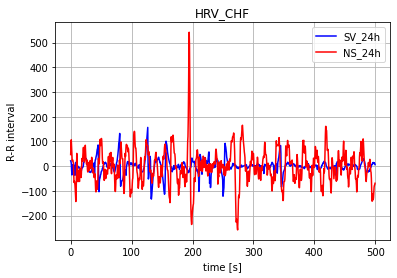

<Figure size 432x288 with 0 Axes>

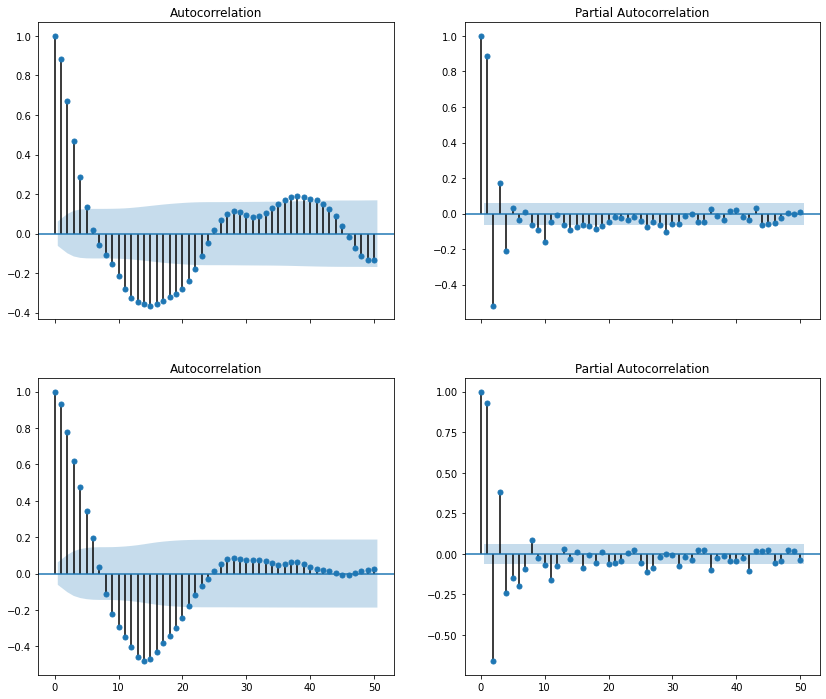

In [116]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fix_length = DAT6.shape[1]   # データ点
dt = 0.5   # second
time_resamp = np.arange(0, fix_length*dt,dt)   # numpy型

SV_data = DAT6.loc[['SV_24h'],:]
NS_data = DAT6.loc[['NS_24h'],:]

plt.figure()
plt.plot(time_resamp, SV_data.iloc[0], color='blue', label=SV_data.index[0])
plt.plot(time_resamp, NS_data.iloc[0], color='red', label=NS_data.index[0])
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('R-R interval')
plt.title('HRV_CHF')
plt.grid()
plt.show()

# 自己相関を求める
plt.figure()
fig, ([ax1, ax2],[ax3, ax4]) = plt.subplots(2, 2, sharex=True, figsize=(14,12))
sm.graphics.tsa.plot_acf(SV_data.iloc[0], lags=50, ax=ax1)
sm.graphics.tsa.plot_pacf(SV_data.iloc[0], lags=50, ax=ax2)
sm.graphics.tsa.plot_acf(NS_data.iloc[0], lags=50, ax=ax3)
sm.graphics.tsa.plot_pacf(NS_data.iloc[0], lags=50, ax=ax4)
plt.show()

In [117]:
# カテゴリ変数を変換

# データをシャッフル
# 参考：https://note.nkmk.me/python-pandas-sample/
df = DAT6.sample(frac=1,axis=0,random_state=0)
df['index'] = df.index
df.loc[:, 'index'] = df.loc[:, 'index'].map({'NS_24h':0, 'SV_24h':1})
DAT6.head()

df_reset = df.reset_index(drop=True) # インデックスを削除
df_reset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,index
0,-17.243071,-26.341014,-31.786802,-28.052961,-21.891622,-15.565754,-13.092365,-14.293598,-15.508855,-16.929631,-18.685969,-18.376041,-13.524664,-7.341303,-1.592800,-0.004839,-2.693520,-1.360521,2.922196,6.661617,9.978941,13.113054,13.447168,9.040127,6.751398,8.609708,10.217914,10.714269,6.396463,-0.025277,-2.559147,-3.280050,-4.539796,-6.408936,-8.955482,-12.280788,-16.294515,-20.804258,-24.866310,-24.906764,...,-19.262888,-22.128006,-25.284326,-31.524808,-37.843860,-39.386953,-40.064980,-43.994798,-45.753852,-41.824131,-38.070519,-36.954683,-35.000695,-31.308767,-25.226116,-16.446286,-12.806372,-12.099078,-3.800417,10.130822,23.957080,35.631058,43.147737,49.539588,56.304606,63.807942,72.397849,77.496160,80.259472,84.004802,93.168405,111.885395,119.046463,109.619353,101.086109,97.129257,102.988480,104.049658,95.782523,1
1,-34.462363,-52.280148,-55.617186,-52.202486,-39.710919,-16.668761,-11.820660,-20.566497,-29.854465,-29.052055,-16.502785,-5.528231,4.684496,15.196428,10.157106,-7.152517,-9.796885,-8.319318,-10.408426,-11.209687,-15.481705,-38.305858,-58.214004,-67.030256,-65.295488,-58.078653,-51.020356,-51.441259,-56.865675,-50.849521,-30.982437,4.492785,46.952190,91.771738,121.872245,142.409480,159.060084,145.702843,106.849992,67.833725,...,-261.975558,-234.374482,-189.606135,-136.334074,-88.145424,-63.585275,-48.946290,-38.747323,-23.889223,-4.281665,19.788318,45.648313,71.387322,79.327529,65.492735,52.502228,42.368667,38.614114,38.870178,41.465789,39.841731,32.860454,3.036600,-35.822894,-58.749355,-65.856711,-57.061797,-43.758419,-27.215492,0.891942,30.608542,34.450584,32.711022,41.540700,57.080861,78.784389,106.870309,137.733258,161.307204,1
2,-4.327742,-4.479202,-4.640430,-4.776433,-4.770679,-2.312540,4.182494,4.459567,4.864696,5.228871,5.643818,6.288345,6.694867,6.907246,7.188914,7.517156,7.669494,7.651653,7.469358,7.286114,6.971656,6.551161,-1.269741,-3.052116,-3.719839,-4.499682,-5.383124,-6.361643,-10.992051,-16.930216,-17.959306,-17.408387,-11.570918,-12.746289,-14.002288,-8.652383,-2.252441,-1.325375,1.678006,7.791313,...,0.497992,0.176651,-0.367040,-1.123227,-2.035304,-2.956146,-3.927084,-5.146275,-6.601062,-1.125960,-1.563146,-3.553279,-5.639158,-2.934477,-1.662575,-4.054343,-6.456991,-6.281187,-1.100340,2.781312,-0.105126,-2.818566,1.839077,6.648827,4.797195,7.339842,6.622797,3.202734,3.938051,4.800614,1.222814,-2.290286,-3.900668,0.660206,4.512423,1.172631,-2.190825,1.529035,-0.255435,1
3,5.285320,9.873513,18.224015,25.772945,25.364435,16.761940,13.069123,9.646689,6.720051,8.037718,4.057125,-1.523298,-2.680804,-10.423492,-15.971394,-12.544163,-15.582212,-18.640415,-19.235301,-26.895149,-33.948157,-36.726715,-35.353791,-33.748324,-33.390117,-33.959732,-35.565731,-37.105918,-34.253315,-26.838154,-16.398104,-6.879605,1.844722,9.936765,17.750993,18.063259,10.765914,8.654715,11.719863,18.647704,...,31.752910,48.418106,65.368052,86.661302,117.622245,141.059059,159.746684,170.940453,168.536899,157.437652,142.685118,129.093494,106.212014,73.851886,32.901368,-15.909466,-73.576008,-131.140440,-180.583451,-237.261040,-300.704941,-370.448798,-445.757993,-517.231893,-565.269340,-557.217632,-492.705623,-371.308581,-252.430486,-136.096430,-25.780915,79.054014,178.599422,276.927073,375.447190,349.219908,265.770505,188.513416,164.706891,1
4,-1.679643,-2.791949,-3.133544,1.753073,4.897253,3.713485,2.318629,0.835424,0.960504,6.549910,8.653133,7.133245,5.403743,3.605219,1.677257,-0.468373,2.737542,5.741091,3.637841,1.552472,-0.516121,-2.527566,-4.466613,-2.562049,2.312295,1.497849,-0.814358,-3.273523,-5.738524,-3.698126,-0.534299,-2.865282,-0.714869,1.734928,-1.342952,-4.332714,-4.437678,0.194057,4.517629,5.345365,...,-0.389512,0.439350,1.538798,2.901668,4

In [118]:
from keras.utils import np_utils

X = df.drop("index", axis = 1)
Y = df["index"]
Y = np_utils.to_categorical(Y, 2)

In [119]:
from sklearn.model_selection import train_test_split

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
print(X.shape, Y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7560, 1000) (7560, 2)
(5670, 1000) (1890, 1000) (5670, 2) (1890, 2)


In [121]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout

In [122]:
model = Sequential()
model.add(LSTM(unit_size, activation = 'relu', input_shape=(1,X_train.shape[1]), return_sequences=False))
model.add(Dropout(dropout))
#model.add(Dense(64))
# model.add(Dense(1, activation='softmax'))
model.add(Dense(2, activation='softmax'))

In [123]:
from keras.callbacks import ModelCheckpoint
path = 'model{epoch:03d}.h5'
modelCheckpoint=ModelCheckpoint(filepath = path,monitor= 'val_loss', verbose=1,save_best_only=True, save_weights_only=False,mode='min', period=1)

In [124]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                272640    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                                                 
Total params: 272,770
Trainable params: 272,770
Non-trainable params: 0
_________________________________________________________________


In [125]:
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)
print(X_train.shape, X_test.shape)

(5670, 1, 1000) (1890, 1, 1000)


In [126]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs = num_epochs, callbacks= [modelCheckpoint], validation_split=0.02)#validation_data=(X_test, y_test))

Epoch 1/100
83/87 [===========================>..] - ETA: 0s - loss: 11.0746 - accuracy: 0.5495
Epoch 00001: val_loss improved from inf to 6.14720, saving model to model001.h5
87/87 [==============================] - 2s 9ms/step - loss: 10.9808 - accuracy: 0.5517 - val_loss: 6.1472 - val_accuracy: 0.6316
Epoch 2/100
80/87 [==========================>...] - ETA: 0s - loss: 5.1771 - accuracy: 0.6154
Epoch 00002: val_loss did not improve from 6.14720
87/87 [==============================] - 0s 6ms/step - loss: 5.1460 - accuracy: 0.6127 - val_loss: 6.1477 - val_accuracy: 0.5789
Epoch 3/100
86/87 [============================>.] - ETA: 0s - loss: 3.0689 - accuracy: 0.6448
Epoch 00003: val_loss improved from 6.14720 to 3.58198, saving model to model003.h5
87/87 [==============================] - 1s 6ms/step - loss: 3.0651 - accuracy: 0.6451 - val_loss: 3.5820 - val_accuracy: 0.5965
Epoch 4/100
79/87 [==========================>...] - ETA: 0s - loss: 2.0511 - accuracy: 0.6711
Epoch 00004: val

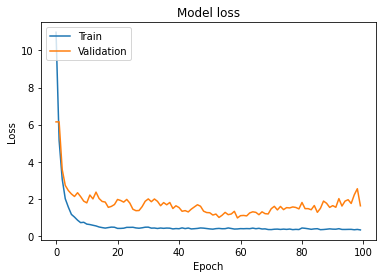

In [127]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [128]:
from keras.models import load_model

In [146]:
xx = 0
for i in range(num_epochs):
  if history.history['val_loss'][i] == min(history.history['val_loss']):
    xx = i + 1

print(xx)

60


In [147]:
model = load_model('/content/model0' + str(xx) + '.h5', compile=True)


y_pred = model.predict(X_test)
y_pred_arg = y_pred.argmax(axis=1)
print(np.count_nonzero(y_pred_arg == 0) / len(y_pred_arg) * 100)
# print(y_test.shape)
#print(y_test[0][0])

26.455026455026452


In [148]:
score = model.evaluate(X_test, y_test, verbose=0)

In [149]:
print(score[1])

0.5751322507858276


In [150]:
# 参考：https://note.nkmk.me/python-sklearn-confusion-matrix-score/

from sklearn.metrics import classification_report
import pandas as pd
import pprint

y_test_arg = y_test.argmax(axis=1)
print(classification_report(y_test_arg, y_pred_arg,
                            target_names=['NS_24h', 'SV_24h']))

              precision    recall  f1-score   support

      NS_24h       0.37      0.27      0.32       673
      SV_24h       0.65      0.74      0.69      1217

    accuracy                           0.58      1890
   macro avg       0.51      0.51      0.50      1890
weighted avg       0.55      0.58      0.56      1890



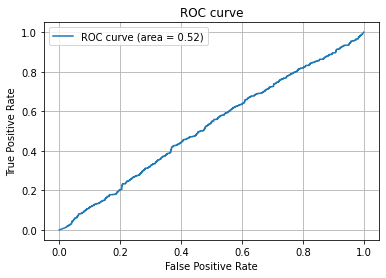

In [151]:
# 参考：https://qiita.com/9pid/items/53946c3ec4b2489e7cb2

from sklearn import metrics
from sklearn.metrics import roc_auc_score

# FPR, TPR(, しきい値) を算出
fpr, tpr, thresholds = metrics.roc_curve(y_test[:, 0], y_pred[:, 0])

# ついでにAUCも
auc = metrics.auc(fpr, tpr)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

# print(roc_auc_score(y_test_arg,y_pred_arg))

In [139]:
print(y_pred[:, 0])
print(y_pred[:100])

[9.8496698e-14 3.1092319e-01 2.9909073e-03 ... 2.1854489e-01 9.8392028e-01
 4.0214099e-02]
[[9.84966977e-14 1.00000000e+00]
 [3.10923189e-01 6.89076841e-01]
 [2.99090729e-03 9.97009099e-01]
 [1.37256584e-05 9.99986291e-01]
 [1.44972221e-08 1.00000000e+00]
 [7.75498393e-06 9.99992251e-01]
 [1.14121736e-04 9.99885917e-01]
 [9.99631286e-01 3.68699461e-04]
 [2.37003654e-01 7.62996376e-01]
 [1.26040206e-04 9.99873996e-01]
 [6.43982828e-01 3.56017172e-01]
 [2.35918490e-03 9.97640848e-01]
 [5.50395548e-01 4.49604481e-01]
 [7.37929577e-03 9.92620707e-01]
 [9.99993920e-01 6.12522535e-06]
 [5.67992032e-01 4.32007998e-01]
 [6.73772544e-02 9.32622790e-01]
 [1.00000000e+00 2.98065770e-15]
 [3.64762102e-03 9.96352434e-01]
 [1.77607998e-01 8.22391987e-01]
 [9.91498530e-01 8.50152224e-03]
 [5.49118280e-01 4.50881720e-01]
 [4.79806751e-01 5.20193219e-01]
 [4.23227012e-01 5.76772988e-01]
 [5.20781279e-01 4.79218692e-01]
 [9.88836408e-01 1.11635085e-02]
 [2.01007891e-02 9.79899168e-01]
 [4.19906806e-03 9